<a href="https://colab.research.google.com/github/14marcos1/onico/blob/main/megasena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Lê corretamente usando ; como separador
df = pd.read_csv(next(iter(uploaded)), sep=";")

# Mostra as colunas corretas
print(df.columns)

# Seleciona somente as bolas
colunas_bolas = ["bola 1", "bola 2", "bola 3", "bola 4", "bola 5", "bola 6"]
dados = df[colunas_bolas].values

# Padroniza
scaler = StandardScaler()
X = scaler.fit_transform(dados)

# K-means
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Adiciona clusters
df["cluster"] = clusters

df.head()


Saving mega_sena_2025.csv to mega_sena_2025 (3).csv
Index(['Concurso', 'Data', 'bola 1', 'bola 2', 'bola 3', 'bola 4', 'bola 5',
       'bola 6'],
      dtype='object')


,Concurso,Data,bola 1,bola 2,bola 3,bola 4,bola 5,bola 6,cluster
0,2954,20/12/2025,37,1,42,44,39,9,0
1,2953,18/12/2025,54,24,47,25,10,5,3
2,2952,16/12/2025,45,51,20,48,1,58,2
3,2951,13/12/2025,8,31,37,30,45,5,5
4,2950,11/12/2025,21,42,50,23,49,60,1



CENTROIDES DOS CLUSTERS
      bola 1     bola 2     bola 3     bola 4     bola 5     bola 6  cluster
0  35.598499  36.067542  33.827392  15.424015  14.677298  22.831144        0
1  18.491363  39.268714  42.525912  34.510557  42.619962  19.596929        1
2  34.031250  21.633929  45.513393  43.319196  21.044643  40.881696        2
3  30.760956  26.069721  26.930279  15.446215  44.095618  42.954183        3
4  44.106426  20.728916  20.311245  39.459839  36.975904  16.803213        4
5  19.683628  37.159292  14.300885  41.037611  22.433628  40.980088        5

DENSIDADE DOS CLUSTERS
   cluster  densidade  n_pontos
0        0   0.527022       533
1        1   0.526620       521
2        2   0.535786       449
3        3   0.513810       502
4        4   0.530681       498
5        5   0.523845       451

CENTROIDES ORDENADOS POR DENSIDADE
      bola 1     bola 2     bola 3     bola 4     bola 5     bola 6  cluster  \
2  34.031250  21.633929  45.513393  43.319196  21.044643  40.881696     

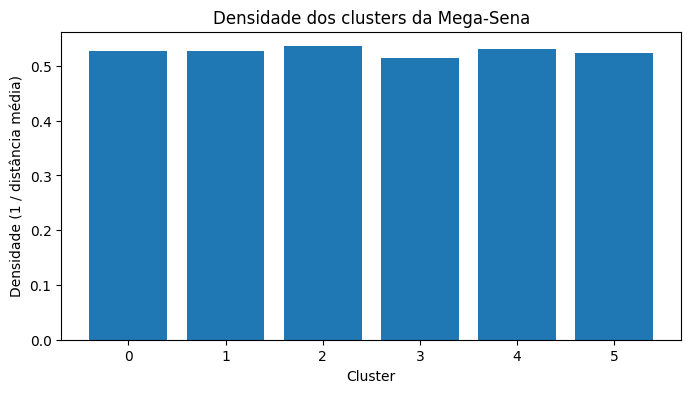

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# === Carrega o CSV corretamente ===
df = pd.read_csv("mega_sena_2025.csv", sep=";")

colunas = ["bola 1","bola 2","bola 3","bola 4","bola 5","bola 6"]
X = df[colunas].values

# === Padroniza ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === K-means ===
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_scaled)

df["cluster"] = clusters

# === Centroides no espaço original (dezenas reais) ===
centroides_scaled = kmeans.cluster_centers_
centroides = scaler.inverse_transform(centroides_scaled)

centroides_df = pd.DataFrame(centroides, columns=colunas)
centroides_df["cluster"] = range(k)

print("\nCENTROIDES DOS CLUSTERS")
print(centroides_df)

# === Densidade de cada cluster ===
# Densidade = inverso da distância média ao centroide
densidades = []

for i in range(k):
    pontos = X_scaled[clusters == i]
    centro = centroides_scaled[i].reshape(1,-1)
    distancias = cdist(pontos, centro)
    densidade = 1 / distancias.mean()
    densidades.append(densidade)

densidade_df = pd.DataFrame({
    "cluster": range(k),
    "densidade": densidades,
    "n_pontos": [(clusters==i).sum() for i in range(k)]
})

print("\nDENSIDADE DOS CLUSTERS")
print(densidade_df)

# === Centroides ordenados por densidade ===
centroides_densos = centroides_df.merge(densidade_df, on="cluster")
centroides_densos = centroides_densos.sort_values("densidade", ascending=False)

print("\nCENTROIDES ORDENADOS POR DENSIDADE")
print(centroides_densos)

# === Visualização: distância média por cluster ===
plt.figure(figsize=(8,4))
plt.bar(centroides_densos["cluster"], centroides_densos["densidade"])
plt.xlabel("Cluster")
plt.ylabel("Densidade (1 / distância média)")
plt.title("Densidade dos clusters da Mega-Sena")
plt.show()


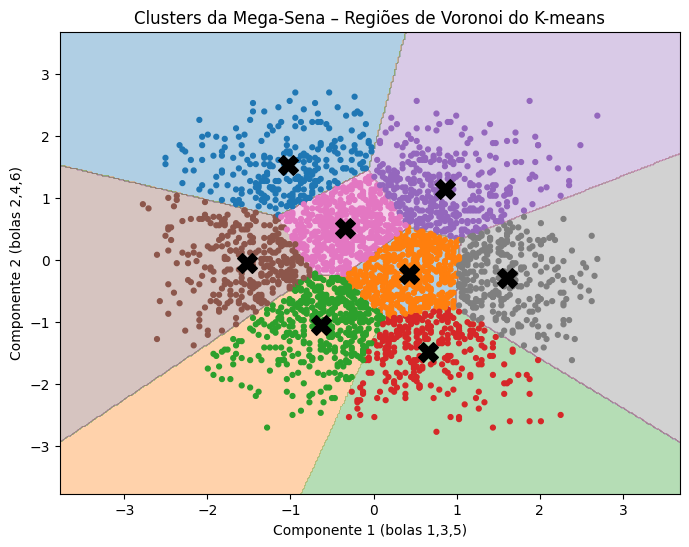

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# === Carregar os dados ===
df = pd.read_csv("mega_sena_2025.csv", sep=";")
colunas = ["bola 1","bola 2","bola 3","bola 4","bola 5","bola 6"]
X = df[colunas].values

# === Reduz para 2 dimensões (média pares e ímpares) para visualização ===
X2 = np.column_stack([
    X[:, [0,2,4]].mean(axis=1),   # bolas 1,3,5
    X[:, [1,3,5]].mean(axis=1)    # bolas 2,4,6
])

# === Padroniza ===
scaler = StandardScaler()
X2s = scaler.fit_transform(X2)

# === K-means ===
k = 8
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = kmeans.fit_predict(X2s)
centroids = kmeans.cluster_centers_

# === Gera a malha (grid) para as regiões de Voronoi ===
h = 0.02
x_min, x_max = X2s[:,0].min()-1, X2s[:,0].max()+1
y_min, y_max = X2s[:,1].min()-1, X2s[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# === Plot ===
plt.figure(figsize=(8,6))
cmap = ListedColormap(plt.cm.tab10.colors[:k])
plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.35)

# Pontos
plt.scatter(X2s[:,0], X2s[:,1], c=labels, cmap=cmap, s=12)

# Centroides
plt.scatter(centroids[:,0], centroids[:,1], c="black", s=200, marker="X")

plt.xlabel("Componente 1 (bolas 1,3,5)")
plt.ylabel("Componente 2 (bolas 2,4,6)")
plt.title("Clusters da Mega-Sena – Regiões de Voronoi do K-means")
plt.show()


In [9]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# Carrega os dados
df = pd.read_csv("mega_sena_2025.csv", sep=";")
colunas = ["bola 1","bola 2","bola 3","bola 4","bola 5","bola 6"]
X = df[colunas].values

# Padroniza
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means
k = 8
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_scaled)

# Distâncias de cada ponto para cada centroide
dist = cdist(X_scaled, kmeans.cluster_centers_)

# Para cada cluster: acha o ponto mais próximo do centroide
prototipos = []

for i in range(k):
    idx = np.where(labels == i)[0]
    idx_closest = idx[np.argmin(dist[idx, i])]
    prototipos.append(df.iloc[idx_closest])

prototipos_df = pd.DataFrame(prototipos)

print("\nSORTEIOS MAIS PRÓXIMOS DE CADA CENTROIDE\n")
display(prototipos_df[colunas + ["Concurso","Data"]])



SORTEIOS MAIS PRÓXIMOS DE CADA CENTROIDE



,bola 1,bola 2,bola 3,bola 4,bola 5,bola 6,Concurso,Data
755,38,23,30,44,35,15,2199,19/10/2019
1243,38,22,50,45,26,39,1711,06/06/2015
2507,24,55,15,33,25,42,447,22/03/2003
808,39,42,16,18,44,31,2146,27/04/2019
2672,33,24,36,9,14,23,282,28/07/2001
2578,25,13,10,43,35,48,376,06/07/2002
65,13,55,40,36,39,16,2889,17/07/2025
2637,27,20,48,16,30,35,317,28/11/2001


In [10]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Carrega os dados
df = pd.read_csv("mega_sena_2025.csv", sep=";")
colunas = ["bola 1","bola 2","bola 3","bola 4","bola 5","bola 6"]
X = df[colunas].values

# Padroniza
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means
k = 8
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
df["cluster"] = kmeans.fit_predict(X_scaled)

# === Médias por cluster ===
medias = df.groupby("cluster")[colunas].mean()

# === Medianas por cluster ===
medianas = df.groupby("cluster")[colunas].median()

# === Junta tudo numa única tabela ===
tabela = pd.concat(
    [medias.add_suffix("_media"), medianas.add_suffix("_mediana")],
    axis=1
)

tabela


,bola 1_media,bola 2_media,bola 3_media,bola 4_media,bola 5_media,bola 6_media,bola 1_mediana,bola 2_mediana,bola 3_mediana,bola 4_mediana,bola 5_mediana,bola 6_mediana
cluster,,,,,,,,,,,,
0,39.741602,14.801034,28.436693,41.937984,37.240310,13.152455,43.0,12.0,28.0,44.0,38.0,12.0
1,40.848649,29.659459,46.091892,43.656757,17.581081,39.108108,43.0,29.0,48.0,46.0,15.0,40.5
2,21.055556,47.086420,16.743827,37.012346,17.086420,38.141975,19.0,49.0,14.5,38.0,14.0,41.0
3,45.720207,38.906736,19.841969,19.932642,45.178756,32.787565,49.0,40.0,18.0,18.0,46.0,33.0
4,36.287179,30.910256,30.643590,13.864103,13.210256,20.697436,37.0,32.0,30.5,12.5,12.0,18.0
5,20.391429,14.594286,17.414286,39.828571,33.217143,43.834286,19.0,13.0,16.0,41.0,35.0,46.0
6,18.524051,45.245570,39.693671,36.982278,40.951899,18.589873,17.0,48.0,41.0,38.0,43.0,17.0
7,18.715909,21.505682,44.903409,15.732955,37.784091,39.252841,16.0,19.0,47.0,13.0,39.0,41.0


            Média  Mediana
bola 1  30.520650     31.0
bola 2  30.325322     31.0
bola 3  30.695328     31.0
bola 4  30.995938     31.0
bola 5  30.516588     31.0
bola 6  30.178741     30.0


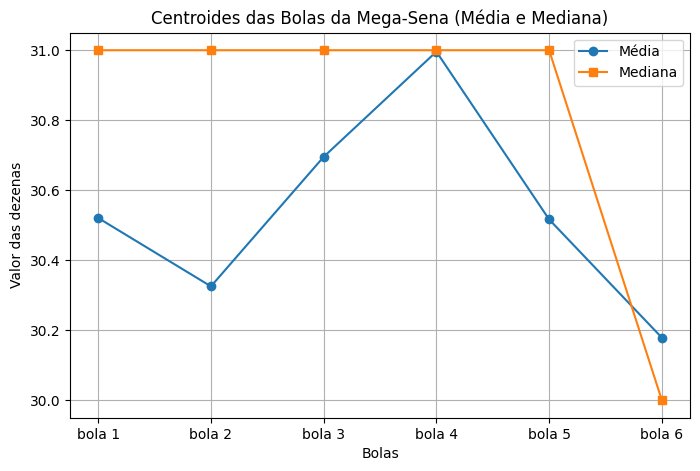

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carrega o CSV
df = pd.read_csv("mega_sena_2025.csv", sep=";")

colunas = ["bola 1","bola 2","bola 3","bola 4","bola 5","bola 6"]

# Calcula os centroides
media = df[colunas].mean()
mediana = df[colunas].median()

# Cria tabela
centroides = pd.DataFrame({
    "Média": media,
    "Mediana": mediana
})

print(centroides)

# === Gráfico ===
plt.figure(figsize=(8,5))

plt.plot(colunas, media, marker="o", label="Média")
plt.plot(colunas, mediana, marker="s", label="Mediana")

plt.xlabel("Bolas")
plt.ylabel("Valor das dezenas")
plt.title("Centroides das Bolas da Mega-Sena (Média e Mediana)")
plt.legend()
plt.grid(True)

plt.show()


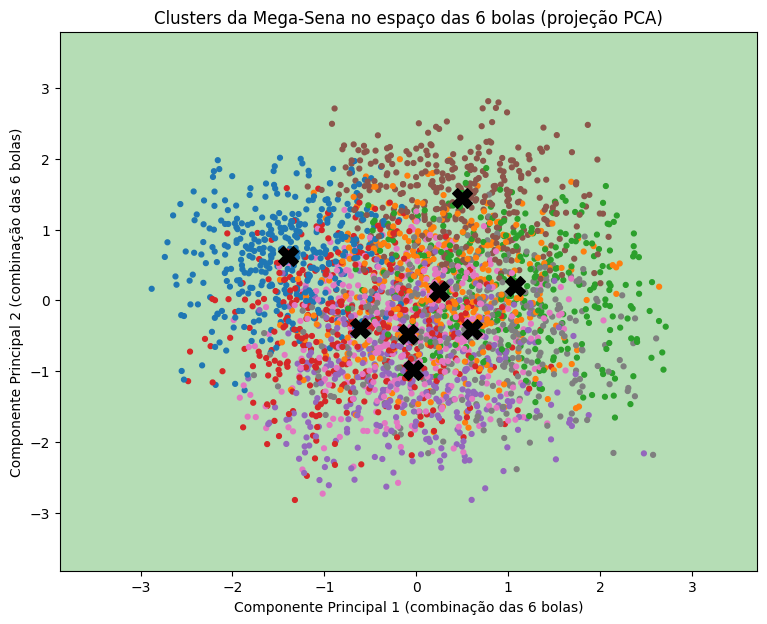

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# === Carrega os dados ===
df = pd.read_csv("mega_sena_2025.csv", sep=";")
bolas = ["bola 1","bola 2","bola 3","bola 4","bola 5","bola 6"]
X = df[bolas].values

# === Padroniza ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === K-means no espaço real (6D) ===
k = 8
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_scaled)

# === Projeta 6D → 2D (PCA) ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
centroids_pca = pca.transform(kmeans.cluster_centers_)

# === Gera malha para Voronoi ===
h = 0.03
x_min, x_max = X_pca[:,0].min()-1, X_pca[:,0].max()+1
y_min, y_max = X_pca[:,1].min()-1, X_pca[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]
grid_6d = pca.inverse_transform(grid)
grid_6d = scaler.transform(grid_6d)

Z = kmeans.predict(grid_6d)
Z = Z.reshape(xx.shape)

# === Plot ===
plt.figure(figsize=(9,7))
cmap = ListedColormap(plt.cm.tab10.colors[:k])

plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.35)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap=cmap, s=12)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c="black", s=200, marker="X")

plt.xlabel("Componente Principal 1 (combinação das 6 bolas)")
plt.ylabel("Componente Principal 2 (combinação das 6 bolas)")
plt.title("Clusters da Mega-Sena no espaço das 6 bolas (projeção PCA)")
plt.show()


Centroides (valores típicos): [ 5.56 15.9  26.54 36.42 45.93 55.41]


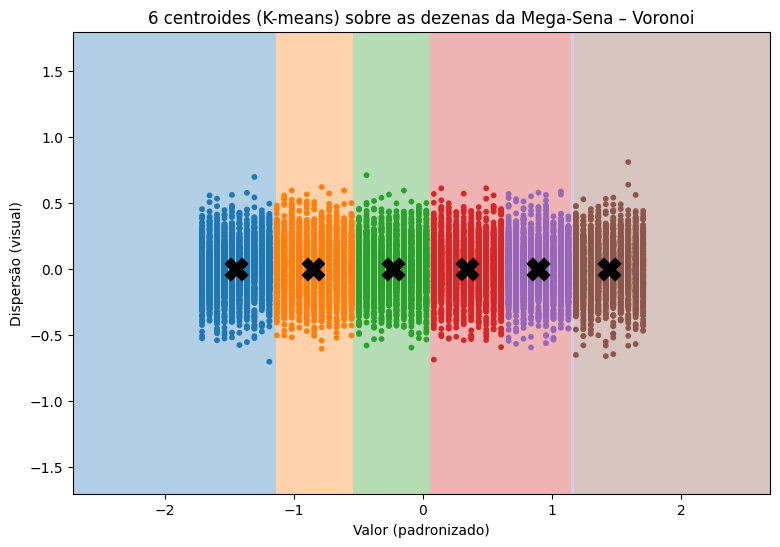

Fronteiras (meio do caminho entre centroides): [10.73 21.22 31.48 41.18 50.67]


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# === 1) Ler CSV (ajuste o nome se estiver diferente no Colab) ===
df = pd.read_csv("mega_sena_2025.csv", sep=";")
bolas = ["bola 1","bola 2","bola 3","bola 4","bola 5","bola 6"]

# === 2) Empilha todas as bolas em 1 coluna (1D) ===
X = df[bolas].to_numpy().reshape(-1, 1)

# === 3) K-means com k=6 (6 centroides) ===
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = kmeans.fit_predict(Xs)

# Centroides no valor original (1..60)
centroides = scaler.inverse_transform(kmeans.cluster_centers_).ravel()
centroides = np.sort(centroides)

print("Centroides (valores típicos):", np.round(centroides, 2))

# === 4) Preparar 2D para plot (x real padronizado + y ruído só para espalhar) ===
np.random.seed(42)
y = np.random.normal(0, 0.18, size=len(Xs))
X2 = np.column_stack([Xs.ravel(), y])

# Reajusta centroides no espaço padronizado (ordenados) para desenhar os X pretos
centroides_s = scaler.transform(centroides.reshape(-1, 1)).ravel()
centroids2 = np.column_stack([centroides_s, np.zeros(k)])

# Para colorir pontos conforme o centroide mais próximo (coerente com centroides ordenados)
# (isso evita “embaralhar” as cores quando o KMeans retorna centroides em outra ordem)
dist = np.abs(Xs.ravel()[:, None] - centroides_s[None, :])
labels_ord = dist.argmin(axis=1)

# === 5) Regiões de Voronoi (em 1D, extrudidas em 2D) ===
h = 0.02
x_min, x_max = X2[:,0].min() - 1, X2[:,0].max() + 1
y_min, y_max = X2[:,1].min() - 1, X2[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Cluster da malha = centroide mais próximo (1D)
gridx = xx.ravel()
Z = np.abs(gridx[:, None] - centroides_s[None, :]).argmin(axis=1).reshape(xx.shape)

# === 6) Plot no estilo Voronoi + centroides ===
plt.figure(figsize=(9, 6))
cmap = ListedColormap(plt.cm.tab10.colors[:k])

plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.35)
plt.scatter(X2[:,0], X2[:,1], c=labels_ord, cmap=cmap, s=10)
plt.scatter(centroids2[:,0], centroids2[:,1], c="black", s=260, marker="X")

plt.xlabel("Valor (padronizado)")
plt.ylabel("Dispersão (visual)")
plt.title("6 centroides (K-means) sobre as dezenas da Mega-Sena – Voronoi")
plt.show()

# === 7) (Opcional) Mostrar intervalos aproximados (fronteiras) entre centroides ===
fronteiras = (centroides[:-1] + centroides[1:]) / 2
print("Fronteiras (meio do caminho entre centroides):", np.round(fronteiras, 2))


In [18]:
import pandas as pd

# Carrega os dados
df = pd.read_csv("mega_sena_2025.csv", sep=";")
bolas = ["bola 1","bola 2","bola 3","bola 4","bola 5","bola 6"]

# Calcula médias e medianas
medias = df[bolas].mean()
medianas = df[bolas].median()

tabela = pd.DataFrame({
    "Média": medias,
    "Mediana": medianas
})

tabela


,Média,Mediana
bola 1,30.520650,31.0
bola 2,30.325322,31.0
bola 3,30.695328,31.0
bola 4,30.995938,31.0
bola 5,30.516588,31.0
bola 6,30.178741,30.0


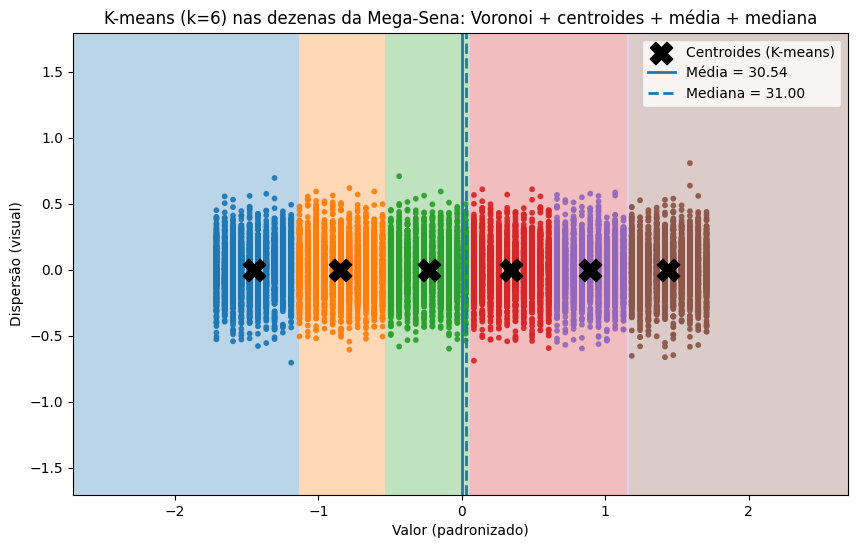

Centroides (K-means): [ 5.56 15.9  26.54 36.42 45.93 55.41]
Média (todas as dezenas empilhadas): 30.5388
Mediana (todas as dezenas empilhadas): 31.0000


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# =========================
# 1) Ler dados
# =========================
df = pd.read_csv("mega_sena_2025.csv", sep=";")
bolas = ["bola 1","bola 2","bola 3","bola 4","bola 5","bola 6"]

# Empilha todas as dezenas (1..60) em 1D (um ponto = uma dezena sorteada)
X = df[bolas].to_numpy().reshape(-1, 1).astype(float)

# =========================
# 2) Média e mediana (no valor original)
# =========================
media = float(X.mean())
mediana = float(np.median(X))

# =========================
# 3) K-means em 1D + padronização
# =========================
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

k = 6  # ajuste se quiser outro k
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
kmeans.fit(Xs)

# Centroides do K-means no valor original
centroides = scaler.inverse_transform(kmeans.cluster_centers_).ravel()
centroides = np.sort(centroides)

# Para colorir: cada ponto vai para o centroide mais próximo (em 1D)
centroides_s = scaler.transform(centroides.reshape(-1, 1)).ravel()
labels_ord = np.abs(Xs.ravel()[:, None] - centroides_s[None, :]).argmin(axis=1)

# =========================
# 4) Preparar 2D (só para visual)
# =========================
np.random.seed(42)
y = np.random.normal(0, 0.18, size=len(Xs))
X2 = np.column_stack([Xs.ravel(), y])
centroids2 = np.column_stack([centroides_s, np.zeros(k)])

# Grid para "Voronoi" (em 1D extrudido)
h = 0.02
x_min, x_max = X2[:,0].min() - 1, X2[:,0].max() + 1
y_min, y_max = X2[:,1].min() - 1, X2[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

gridx = xx.ravel()
Z = np.abs(gridx[:, None] - centroides_s[None, :]).argmin(axis=1).reshape(xx.shape)

# =========================
# 5) Plot: Voronoi + centroides + média + mediana
# =========================
plt.figure(figsize=(10, 6))
cmap = ListedColormap(plt.cm.tab10.colors[:k])

plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.30)
plt.scatter(X2[:,0], X2[:,1], c=labels_ord, cmap=cmap, s=10, alpha=0.9)

# Centroides K-means (X pretos)
plt.scatter(centroids2[:,0], centroids2[:,1], c="black", s=260, marker="X", label="Centroides (K-means)")

# Média e mediana como linhas verticais (no espaço padronizado)
media_s = float(scaler.transform([[media]])[0,0])
mediana_s = float(scaler.transform([[mediana]])[0,0])

plt.axvline(media_s, linewidth=2, label=f"Média = {media:.2f}")
plt.axvline(mediana_s, linewidth=2, linestyle="--", label=f"Mediana = {mediana:.2f}")

plt.xlabel("Valor (padronizado)")
plt.ylabel("Dispersão (visual)")
plt.title(f"K-means (k={k}) nas dezenas da Mega-Sena: Voronoi + centroides + média + mediana")
plt.legend()
plt.show()

# =========================
# 6) Tabela resumo (valores originais)
# =========================
tabela = pd.DataFrame({
    "Centroides_Kmeans": np.round(centroides, 2)
})
print("Centroides (K-means):", np.round(centroides, 2))
print(f"Média (todas as dezenas empilhadas): {media:.4f}")
print(f"Mediana (todas as dezenas empilhadas): {mediana:.4f}")


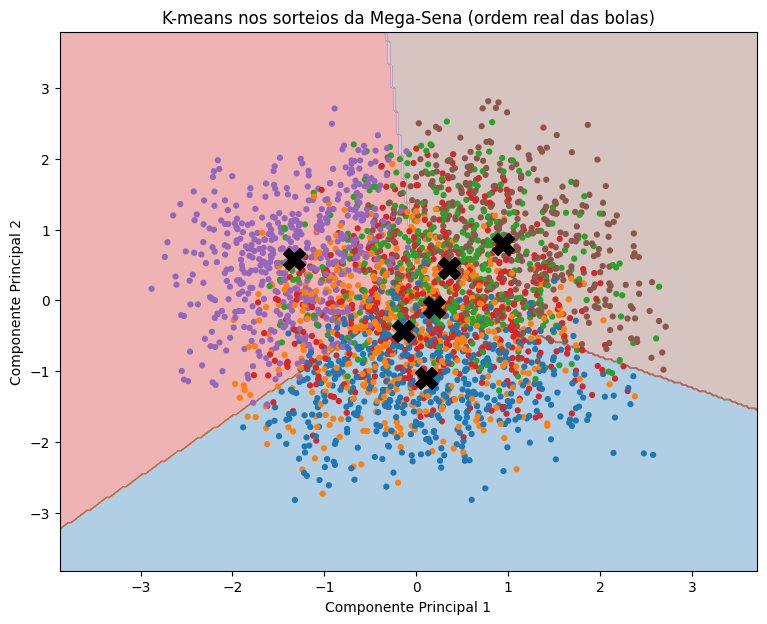

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# === 1) Carregar dados reais (ordem de sorteio preservada) ===
df = pd.read_csv("mega_sena_2025.csv", sep=";")
bolas = ["bola 1","bola 2","bola 3","bola 4","bola 5","bola 6"]
X = df[bolas].values

# === 2) Padronizar ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 3) K-means em 6D ===
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_scaled)

# === 4) PCA 6D → 2D para visualização ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
centroids_pca = pca.transform(kmeans.cluster_centers_)

# === 5) Regiões de Voronoi no espaço PCA ===
h = 0.03
x_min, x_max = X_pca[:,0].min()-1, X_pca[:,0].max()+1
y_min, y_max = X_pca[:,1].min()-1, X_pca[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]

# Volta grid → 6D → prediz cluster
grid_6d = scaler.inverse_transform(pca.inverse_transform(grid))
grid_6d = scaler.transform(grid_6d)
Z = kmeans.predict(grid_6d).reshape(xx.shape)

# === 6) Plot ===
plt.figure(figsize=(9,7))
cmap = ListedColormap(plt.cm.tab10.colors[:k])

plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.35)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap=cmap, s=12)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c="black", s=250, marker="X")

plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("K-means nos sorteios da Mega-Sena (ordem real das bolas)")
plt.show()


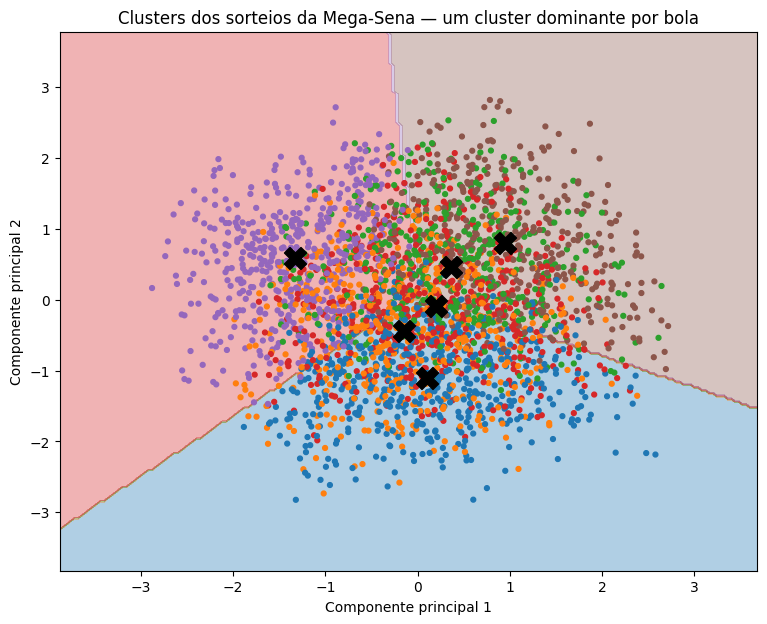

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# === Carrega os dados ===
df = pd.read_csv("mega_sena_2025.csv", sep=";")
bolas = ["bola 1","bola 2","bola 3","bola 4","bola 5","bola 6"]
X = df[bolas].values

# === Padroniza ===
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# === K-means com 6 clusters ===
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = kmeans.fit_predict(Xs)

# === PCA 6D → 2D ===
pca = PCA(n_components=2)
Xp = pca.fit_transform(Xs)
centroids_pca = pca.transform(kmeans.cluster_centers_)

# === Região de Voronoi ===
h = 0.04
x_min, x_max = Xp[:,0].min()-1, Xp[:,0].max()+1
y_min, y_max = Xp[:,1].min()-1, Xp[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]
grid_6d = scaler.inverse_transform(pca.inverse_transform(grid))
grid_6d = scaler.transform(grid_6d)
Z = kmeans.predict(grid_6d).reshape(xx.shape)

# === Plot ===
plt.figure(figsize=(9,7))
cmap = ListedColormap(plt.cm.tab10.colors[:k])

plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.35)
plt.scatter(Xp[:,0], Xp[:,1], c=labels, cmap=cmap, s=12)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c="black", s=250, marker="X")

plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.title("Clusters dos sorteios da Mega-Sena — um cluster dominante por bola")
plt.show()


In [22]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

# === Carregar dados ===
df = pd.read_csv("mega_sena_2025.csv", sep=";")
bolas = ["bola 1","bola 2","bola 3","bola 4","bola 5","bola 6"]
X = df[bolas].values

# === Padronizar ===
Xs = StandardScaler().fit_transform(X)

# === K-means em 6D ===
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = kmeans.fit_predict(Xs)

# === PCA 6D → 3D ===
pca = PCA(n_components=3)
Xp = pca.fit_transform(Xs)

# === DataFrame para plot ===
df_plot = pd.DataFrame(Xp, columns=["PC1","PC2","PC3"])
df_plot["cluster"] = labels.astype(str)

# === Plot interativo 3D ===
fig = px.scatter_3d(
    df_plot,
    x="PC1", y="PC2", z="PC3",
    color="cluster",
    title="PCA 3D dos sorteios da Mega-Sena (K-means, k=6)",
    opacity=0.7
)

fig.show()


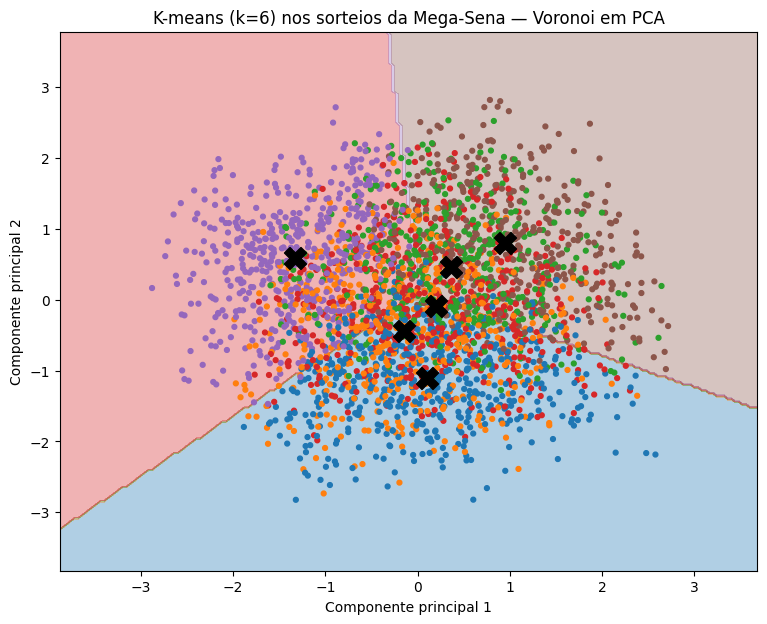


CENTROIDES REAIS (valores típicos de cada bola por cluster)



,bola 1,bola 2,bola 3,bola 4,bola 5,bola 6,Cluster
0,35.598499,36.067542,33.827392,15.424015,14.677298,22.831144,0
1,18.491363,39.268714,42.525912,34.510557,42.619962,19.596929,1
2,34.031250,21.633929,45.513393,43.319196,21.044643,40.881696,2
3,30.760956,26.069721,26.930279,15.446215,44.095618,42.954183,3
4,44.106426,20.728916,20.311245,39.459839,36.975904,16.803213,4
5,19.683628,37.159292,14.300885,41.037611,22.433628,40.980088,5


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# === 1) Carregar dados (ordem real de sorteio) ===
df = pd.read_csv("mega_sena_2025.csv", sep=";")
bolas = ["bola 1","bola 2","bola 3","bola 4","bola 5","bola 6"]
X = df[bolas].values

# === 2) Padronizar ===
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# === 3) K-means em 6D ===
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = kmeans.fit_predict(Xs)

# === 4) PCA 6D → 2D ===
pca = PCA(n_components=2)
Xp = pca.fit_transform(Xs)
centroids_pca = pca.transform(kmeans.cluster_centers_)

# === 5) Regiões de Voronoi no espaço PCA ===
h = 0.04
x_min, x_max = Xp[:,0].min()-1, Xp[:,0].max()+1
y_min, y_max = Xp[:,1].min()-1, Xp[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]
grid_6d = scaler.inverse_transform(pca.inverse_transform(grid))
grid_6d = scaler.transform(grid_6d)
Z = kmeans.predict(grid_6d).reshape(xx.shape)

# === 6) Plot (igual à sua figura) ===
plt.figure(figsize=(9,7))
cmap = ListedColormap(plt.cm.tab10.colors[:k])

plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.35)
plt.scatter(Xp[:,0], Xp[:,1], c=labels, cmap=cmap, s=12)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c="black", s=250, marker="X")

plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.title("K-means (k=6) nos sorteios da Mega-Sena — Voronoi em PCA")
plt.show()

# === 7) Centroides reais (em dezenas) ===
centroides_reais = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=bolas
)

centroides_reais["Cluster"] = range(k)

print("\nCENTROIDES REAIS (valores típicos de cada bola por cluster)\n")
display(centroides_reais)


In [27]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# === Ler dados ===
df = pd.read_csv("mega_sena_2025.csv", sep=";")
bolas = ["bola 1","bola 2","bola 3","bola 4","bola 5","bola 6"]
X = df[bolas].values

# === Padronizar ===
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# === K-means (mesmos parâmetros do seu gráfico) ===
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = kmeans.fit_predict(Xs)

# === Distância de cada sorteio ao centroide do seu cluster ===
centros = kmeans.cluster_centers_
dist_to_own = np.linalg.norm(Xs - centros[labels], axis=1)

df_out = df.copy()
df_out["cluster"] = labels
df_out["dist_ao_centroide"] = dist_to_own

# === 1) O sorteio MAIS PRÓXIMO de cada X (um por cluster) ===
mais_proximos = (
    df_out.sort_values("dist_ao_centroide")
          .groupby("cluster", as_index=False)
          .head(1)
          .sort_values("cluster")
)

print("SORTEIO MAIS PRÓXIMO DE CADA CENTROIDE (X)\n")
display(mais_proximos[["cluster","Concurso","Data"] + bolas + ["dist_ao_centroide"]])

# === 2) (Opcional) TOP 10 mais próximos de cada X ===
topN = 10
top_por_cluster = (
    df_out.sort_values("dist_ao_centroide")
          .groupby("cluster", as_index=False)
          .head(topN)
          .sort_values(["cluster","dist_ao_centroide"])
)

print(f"\nTOP {topN} SORTEIOS MAIS PRÓXIMOS DE CADA CENTROIDE\n")
display(top_por_cluster[["cluster","Concurso","Data"] + bolas + ["dist_ao_centroide"]])


SORTEIO MAIS PRÓXIMO DE CADA CENTROIDE (X)



,cluster,Concurso,Data,bola 1,bola 2,bola 3,bola 4,bola 5,bola 6,dist_ao_centroide
142,0,2812,07/01/2025,39,42,31,15,18,27,0.527495
999,1,1955,05/08/2017,15,41,45,33,36,27,0.642545
1243,2,1711,06/06/2015,38,22,50,45,26,39,0.474119
1040,3,1914,22/03/2017,39,33,29,16,44,42,0.636165
441,4,2513,24/08/2022,50,21,13,46,35,19,0.683948
624,5,2330,31/12/2020,22,35,17,41,20,42,0.284881



TOP 10 SORTEIOS MAIS PRÓXIMOS DE CADA CENTROIDE



,cluster,Concurso,Data,bola 1,bola 2,bola 3,bola 4,bola 5,bola 6,dist_ao_centroide
142,0,2812,07/01/2025,39,42,31,15,18,27,0.527495
259,0,2695,02/03/2024,40,33,34,17,15,32,0.624448
2596,0,358,04/05/2002,40,42,32,12,21,17,0.694254
1084,0,1870,26/10/2016,30,40,33,18,20,32,0.749452
2237,0,717,26/11/2005,28,35,41,17,6,23,0.794845
1637,0,1317,08/09/2011,35,29,37,13,6,30,0.804873
2672,0,282,28/07/2001,33,24,36,9,14,23,0.811389
2426,0,528,10/01/2004,34,28,37,12,8,31,0.820278
2048,0,906,29/09/2007,35,39,29,24,7,14,0.904275
1229,0,1725,22/07/2015,26,31,30,18,16,34,0.945526


In [28]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# === Ler dados ===
df = pd.read_csv("mega_sena_2025.csv", sep=";")
bolas = ["bola 1","bola 2","bola 3","bola 4","bola 5","bola 6"]
X = df[bolas].values

# === Padronizar ===
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# === K-means (mesmos parâmetros do seu gráfico) ===
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = kmeans.fit_predict(Xs)

# === Distância de cada sorteio ao centroide do SEU cluster ===
centros = kmeans.cluster_centers_
dist = np.linalg.norm(Xs - centros[labels], axis=1)

df_out = df.copy()
df_out["cluster"] = labels
df_out["dist_ao_centroide"] = dist

# === Mais próximo e mais longe por cluster ===
mais_proximo = (
    df_out.sort_values("dist_ao_centroide")
          .groupby("cluster", as_index=False)
          .head(1)
          .sort_values("cluster")
)

mais_longe = (
    df_out.sort_values("dist_ao_centroide", ascending=False)
          .groupby("cluster", as_index=False)
          .head(1)
          .sort_values("cluster")
)

print("MAIS PRÓXIMO DE CADA CENTROIDE (por cluster)\n")
display(mais_proximo[["cluster","Concurso","Data"] + bolas + ["dist_ao_centroide"]])

print("\nMAIS LONGE DE CADA CENTROIDE (por cluster)\n")
display(mais_longe[["cluster","Concurso","Data"] + bolas + ["dist_ao_centroide"]])


MAIS PRÓXIMO DE CADA CENTROIDE (por cluster)



,cluster,Concurso,Data,bola 1,bola 2,bola 3,bola 4,bola 5,bola 6,dist_ao_centroide
142,0,2812,07/01/2025,39,42,31,15,18,27,0.527495
999,1,1955,05/08/2017,15,41,45,33,36,27,0.642545
1243,2,1711,06/06/2015,38,22,50,45,26,39,0.474119
1040,3,1914,22/03/2017,39,33,29,16,44,42,0.636165
441,4,2513,24/08/2022,50,21,13,46,35,19,0.683948
624,5,2330,31/12/2020,22,35,17,41,20,42,0.284881



MAIS LONGE DE CADA CENTROIDE (por cluster)



,cluster,Concurso,Data,bola 1,bola 2,bola 3,bola 4,bola 5,bola 6,dist_ao_centroide
156,0,2798,19/11/2024,9,59,60,3,18,54,3.199319
54,1,2900,12/08/2025,60,59,55,54,50,33,3.107744
902,2,2052,23/06/2018,57,50,56,51,58,59,3.273917
1919,3,1035,31/12/2008,51,60,1,11,59,26,3.032412
2008,4,946,23/02/2008,59,1,47,5,52,12,3.037073
1907,5,1047,11/02/2009,1,2,10,48,14,8,3.065640


In [29]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# === Ler dados ===
df = pd.read_csv("mega_sena_2025.csv", sep=";")
bolas = ["bola 1","bola 2","bola 3","bola 4","bola 5","bola 6"]
X = df[bolas].values

# === Padronizar ===
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# === K-means ===
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
kmeans.fit(Xs)

# === Distância de cada sorteio ao centroide GLOBAL (média dos centroides) ===
centro_global = kmeans.cluster_centers_.mean(axis=0)
dist_global = np.linalg.norm(Xs - centro_global, axis=1)

df_out = df.copy()
df_out["dist_ao_centro_global"] = dist_global

# === Sorteio mais central de todos ===
mais_central = df_out.loc[df_out["dist_ao_centro_global"].idxmin()]

print("SORTEIO MAIS PRÓXIMO DO CONJUNTO DOS X (centro global)\n")
print(mais_central[["Concurso","Data"] + bolas + ["dist_ao_centro_global"]])


SORTEIO MAIS PRÓXIMO DO CONJUNTO DOS X (centro global)

Concurso                       2576
Data                     22/03/2023
bola 1                           32
bola 2                           29
bola 3                           43
bola 4                           35
bola 5                           38
bola 6                           33
dist_ao_centro_global      0.885919
Name: 378, dtype: object


In [30]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# === Ler dados ===
df = pd.read_csv("mega_sena_2025.csv", sep=";")
bolas = ["bola 1","bola 2","bola 3","bola 4","bola 5","bola 6"]
X = df[bolas].values

# === Padronizar ===
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# === K-means ===
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = kmeans.fit_predict(Xs)

centros = kmeans.cluster_centers_

# === Para cada sorteio: distância ao centroide do seu cluster ===
dist = np.linalg.norm(Xs - centros[labels], axis=1)

df_out = df.copy()
df_out["cluster"] = labels
df_out["dist_ao_centroide"] = dist

# === Sorteio mais distante (global) em relação ao seu centroide ===
idx = df_out["dist_ao_centroide"].idxmax()
mais_longe = df_out.loc[idx]

print("SEQUÊNCIA MAIS LONGE DE UM X (a maior distância ao centroide do próprio cluster)\n")
print(mais_longe[["Concurso","Data"] + bolas + ["cluster","dist_ao_centroide"]])


SEQUÊNCIA MAIS LONGE DE UM X (a maior distância ao centroide do próprio cluster)

Concurso                   2052
Data                 23/06/2018
bola 1                       57
bola 2                       50
bola 3                       56
bola 4                       51
bola 5                       58
bola 6                       59
cluster                       2
dist_ao_centroide      3.273917
Name: 902, dtype: object
